# Modeling 1-star and 5-star reviews using Natural Language Processing (NLP) with Naive Bayes and Random Forests

[Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk#natural language tool kit for NLP

# Data Loading and Exploration

In [4]:
yelp=pd.read_csv('yelp.csv')
yelp.head(3)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0


In [5]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [6]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [65]:
yelp['text length'] = yelp['text'].apply(len)
yelp#To check length feature as an attribute for correlation of text with rating

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,76
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469
...,...,...,...,...,...,...,...,...,...,...,...
9995,VY_tvNUCCXGXQeSvJl757Q,2012-07-28,Ubyfp2RSDYW0g7Mbr8N3iA,3,First visit...Had lunch here today - used my G...,review,_eqQoPtQ3e3UxLE4faT6ow,1,2,0,668
9996,EKzMHI1tip8rC1-ZAy64yg,2012-01-18,2XyIOQKbVFb6uXQdJ0RzlQ,4,Should be called house of deliciousness!\n\nI ...,review,ROru4uk5SaYc3rg8IU7SQw,0,0,0,881
9997,53YGfwmbW73JhFiemNeyzQ,2010-11-16,jyznYkIbpqVmlsZxSDSypA,4,I recently visited Olive and Ivy for business ...,review,gGbN1aKQHMgfQZkqlsuwzg,0,0,0,1425
9998,9SKdOoDHcFoxK5ZtsgHJoA,2012-12-02,5UKq9WQE1qQbJ0DJbc-B6Q,2,My nephew just moved to Scottsdale recently so...,review,0lyVoNazXa20WzUyZPLaQQ,0,0,0,880


# EDA

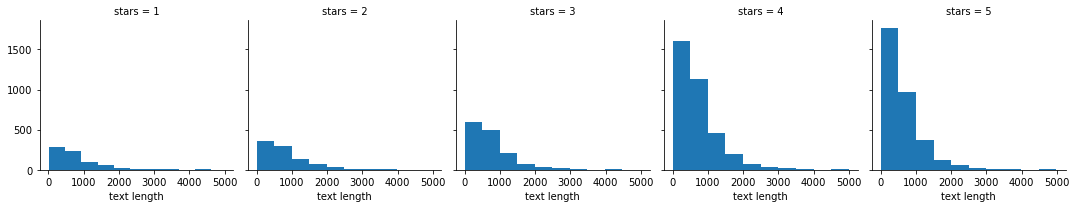

In [13]:
g = sns.FacetGrid(yelp, col='stars')
g.map(plt.hist, 'text length')

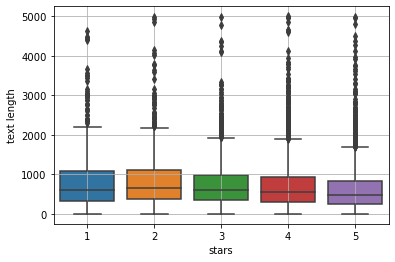

In [18]:
sns.boxplot(x='stars',y='text length',data=yelp)
plt.grid()
plt.show()

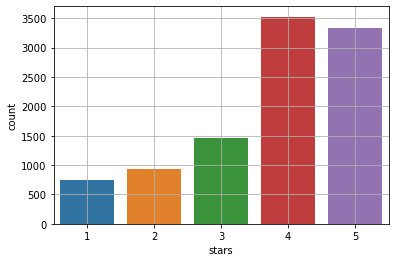

In [21]:
sns.countplot(x='stars',data=yelp)
plt.grid()

In [26]:
stars = yelp.groupby(by='stars').mean()

In [28]:
yelp_corr = stars.corr()
yelp_corr

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


<AxesSubplot:>

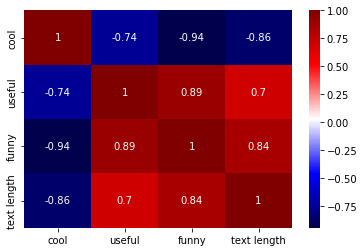

In [30]:
sns.heatmap(yelp_corr, cmap='seismic', annot=True)

## NLP Classification

In [64]:
yelp_class = yelp[(yelp['stars']==1)|(yelp['stars']==5)]#Tostore binary labels and features for stars=1 or stars=5
yelp_class

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469
6,zp713qNhx8d9KCJJnrw1xA,2010-02-12,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...,review,wFweIWhv2fREZV_dYkz_1g,7,7,4,1565
...,...,...,...,...,...,...,...,...,...,...,...
9990,R8VwdLyvsp9iybNqRvm94g,2011-10-03,pcEeHdAJPoFNF23es0kKWg,5,Yes I do rock the hipster joints. I dig this ...,review,b92Y3tyWTQQZ5FLifex62Q,1,1,1,263
9991,WJ5mq4EiWYAA4Vif0xDfdg,2011-12-05,EuHX-39FR7tyyG1ElvN1Jw,5,Only 4 stars? \n\n(A few notes: The folks that...,review,hTau-iNZFwoNsPCaiIUTEA,1,1,0,908
9992,f96lWMIAUhYIYy9gOktivQ,2009-03-10,YF17z7HWlMj6aezZc-pVEw,5,I'm not normally one to jump at reviewing a ch...,review,W_QXYA7A0IhMrvbckz7eVg,2,3,2,1326
9994,L3BSpFvxcNf3T_teitgt6A,2012-03-19,0nxb1gIGFgk3WbC5zwhKZg,5,Let's see...what is there NOT to like about Su...,review,OzOZv-Knlw3oz9K5Kh5S6A,1,2,1,1968


In [63]:
X = yelp_class['text']#Features from text only-Feature Engineering can increase the number of features a lot
y = yelp_class['stars']#Labels-Binary Classification either stars=1 or stars=5

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()#Vectorization

In [44]:
X_cv = cv.fit_transform(X)#gives vocab, character encoding

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X_cv, y, test_size=0.3)

## Training to Learn Model

In [47]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()

In [48]:
nb.fit(X_train, Y_train)

MultinomialNB()

In [50]:
predictions_nb = nb.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print('Naive Bayes Classifier NLP')
print(classification_report(predictions_nb,Y_test))
print('\n')
print(confusion_matrix(predictions_nb,Y_test))

Naive Bayes Classifier NLP
              precision    recall  f1-score   support

           1       0.67      0.83      0.74       175
           5       0.97      0.93      0.95      1051

    accuracy                           0.92      1226
   macro avg       0.82      0.88      0.85      1226
weighted avg       0.93      0.92      0.92      1226



[[145  30]
 [ 70 981]]


# Text Modeling

In [62]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([('bow',CountVectorizer()),('tfidf',TfidfTransformer()),('Classifier',RandomForestClassifier())])
X = yelp_class['text']
Y = yelp_class['stars']
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.3)
pipeline.fit(X_train,Y_train)
predictions = pipeline.predict(X_test)
print('Random Forest Classifier pipeline')
print(classification_report(predictions,Y_test))
print('\n')
print(confusion_matrix(predictions,Y_test))

Random Forest Classifier pipeline
              precision    recall  f1-score   support

           1       0.23      0.98      0.37        50
           5       1.00      0.86      0.92      1176

    accuracy                           0.87      1226
   macro avg       0.61      0.92      0.65      1226
weighted avg       0.97      0.87      0.90      1226



[[  49    1]
 [ 164 1012]]
